In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [87]:
# Cargamos los datos
car_data = pd.read_csv('../data/car_data_clean.csv', sep=',')

In [88]:
# Definimos las variables predictoras y la variable objetivo
X = car_data.drop(labels=['Mas_1_coche'], axis=1)
y = car_data['Mas_1_coche']

In [89]:
# Estandarizamos los datos

# Creamos un objeto StandardScaler
scaler = StandardScaler()

# 1º Filtramos las columnas que tengan valores mayores a 1
cols = [col for col in X.columns if X[col].max() > 1]

# 2º Ajustamos y escalamos las columnas especificadas
for col in cols:
    X[col] = scaler.fit_transform(X[[col]])  # Escalamos cada columna de manera individual

In [90]:
# Dividimos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [91]:
# Entrenamos el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=912)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

In [92]:
# Entrenamos el modelo de Extreme Gradient Boosting
xgb_model = XGBClassifier(random_state=912)

In [93]:
class Model:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train_random_forest(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', RandomForestClassifier(n_estimators=100, random_state=42))])
        random_forest_model = pipeline.fit(self.x_train, self.y_train)
        return random_forest_model

    def train_gradient_boosting(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', GradientBoostingClassifier(random_state=912))])
        gradient_boosting_model = pipeline.fit(self.x_train, self.y_train)
        return gradient_boosting_model

    def train_XGB(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', XGBClassifier(random_state=912))])
        gradient_boosting_model = pipeline.fit(self.x_train, self.y_train)
        return gradient_boosting_model

model = Model(X_train, X_test, y_train, y_test)
GB_model = model.train_gradient_boosting()
RF_model = model.train_random_forest()
XGBClassifier_model = model.train_XGB()


In [94]:
class Evaluation:
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test
    
    def evaluate_model(self):
        y_pred = self.model.predict(self.x_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        auc = roc_auc_score(self.y_test, self.model.predict_proba(self.x_test), multi_class='ovr')
        confusion = confusion_matrix(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)
        
        print("Model:", self.model)
        print("Overall Accuracy:", accuracy)
        print("Overall Precision:", precision)
        print("Overall Recall:", recall)
        print("Average AUC:", auc)
        return accuracy, precision, recall, confusion, report
    
    def plot(self, model_name):
        y_pred = self.model.predict(self.x_test)
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        
        plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xticks(np.arange(len(conf_matrix)), ['No compra', 'Compra'], rotation=45)
        plt.yticks(np.arange(len(conf_matrix)), ['No compra', 'Compra'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix for " + model_name)

        for i in range(len(conf_matrix)):
            for j in range(len(conf_matrix[0])):
                plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")

        plt.show()

        partidos_prob = self.model.predict_proba(self.x_test)

        fpr = {}
        tpr = {}
        thresh = {}
        for i in range(len(self.model.classes_)):    
            fpr[i], tpr[i], thresh[i] = roc_curve(self.y_test, partidos_prob[:, i], pos_label=i)
                
        plt.plot(fpr[1], tpr[1], linestyle='--', color='blue', label='Compra vs No compra')

        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='best')
        plt.show()

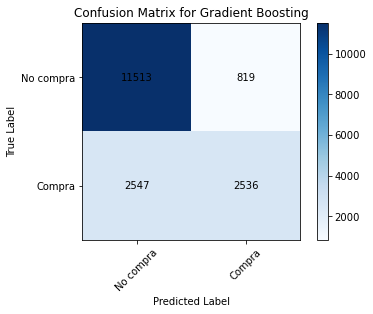

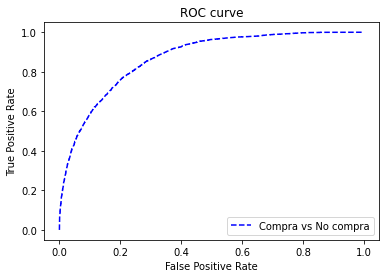

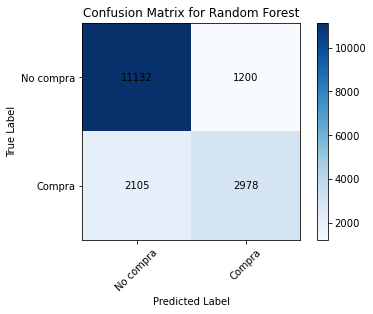

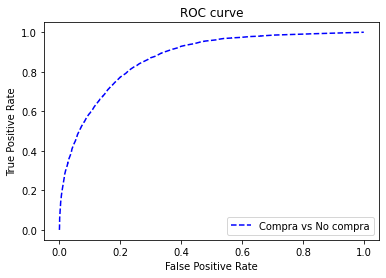

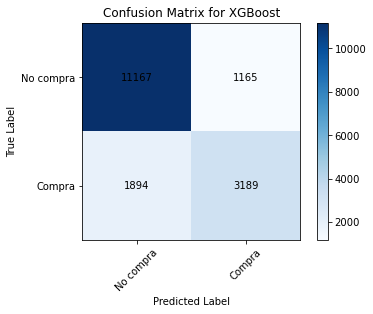

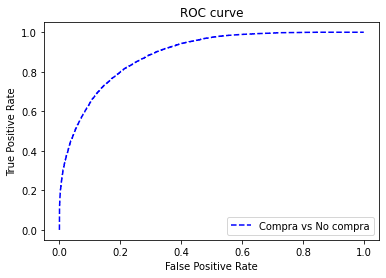

In [95]:
evaluation_GB = Evaluation(GB_model, X_test, y_test)
evaluation_RF = Evaluation(RF_model, X_test, y_test)
evaluation_XGB = Evaluation(XGBClassifier_model, X_test, y_test)

#Graficas de evaluacion
evaluation_GB.plot('Gradient Boosting')
evaluation_RF.plot('Random Forest')
evaluation_XGB.plot('XGBoost')

In [96]:
#Probabilidad de cada registro de pertenecer a cada clase 
y_scores = GB_model.predict_proba(X_test)
print(y_scores)

[[0.4913277  0.5086723 ]
 [0.85331871 0.14668129]
 [0.98052971 0.01947029]
 ...
 [0.74187571 0.25812429]
 [0.85211498 0.14788502]
 [0.57131905 0.42868095]]


In [97]:
# Evaluación de todos los modelos escalados, ya que tienen mejor rendimiento

modelos = {
    'Random Forest': RF_model,
    'Gradient Boosting': GB_model,
    'XGBoost': XGBClassifier_model
}

# Crear un diccionario para almacenar las métricas de cada modelo
metricas = {}

# Iterar sobre cada modelo
for nombre, modelo in modelos.items():
    # Realizar predicciones en el conjunto de prueba
    predicciones = modelo.predict(X_test)
    predicciones_proba = modelo.predict_proba(X_test)

    # Calcular las métricas
    accuracy = accuracy_score(y_test, predicciones)
    precision = precision_score(y_test, predicciones, average='macro')
    recall = recall_score(y_test, predicciones, average='macro')

    # Calcular AUC usando las probabilidades de la clase positiva (o clase 1)
    roc_auc = roc_auc_score(y_test, predicciones_proba[:, 1])  # Cambia el índice según la clase que te interese

    # Almacenar las métricas en el diccionario
    metricas[nombre] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUC': roc_auc
    }

# Crear un DataFrame a partir del diccionario de métricas
df_metricas = pd.DataFrame.from_dict(metricas, orient='index')

# Imprimir el DataFrame
print(df_metricas)

                   Accuracy  Precision    Recall       AUC
Random Forest      0.810221   0.776879  0.744283  0.870200
Gradient Boosting  0.806718   0.787367  0.716253  0.869048
XGBoost            0.824347   0.793709  0.766458  0.889672
